In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate,  StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from plotly.subplots import make_subplots
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder as le
from collections import defaultdict
from collections import Counter
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve, make_scorer, plot_precision_recall_curve
import joblib
import pickle


In [2]:
hrd_train = pd.read_csv('hrd_for_modelling.csv')

In [3]:
X = hrd_train.drop(columns=['target','Unnamed: 0', 'enrollee_id', 'city'])
y = hrd_train['target']

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base Model

In [5]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
xgb = XGBClassifier()
smote = SMOTE()

In [6]:
ordinal_mapping = [
    {'col' : 'education_level',
    'mapping':{'Primary School':1, 'High School':2, 'Graduate':3, 'Masters':4}},
    {'col' : 'relevent_experience',
    'mapping':{'No relevent experience':1, 'Has relevent experience':2}},
    {'col' : 'experience',
    'mapping':{'<1':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11,'12':12, '13':13, '14':14, '15':15, '16':16, '17':17, '18':18, '19':19, '20':20, '>20':21 }},
    {'col' : 'last_new_job',
    'mapping':{'never':0, '1':1,'2':2,'3':3,'4':4, '>4':4}},
]

ordinal_encoder = ce.OrdinalEncoder(cols=['education_level','relevent_experience','experience','last_new_job'],mapping=ordinal_mapping)

## Logistic Regression Pipeline

In [7]:
lr_pipe_num = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

lr_transformer = ColumnTransformer([
    ('pipe_num', lr_pipe_num, ['city_development_index', 'training_hours']),
    ('onehot', OneHotEncoder(drop='first'),['gender','enrolled_university','major_discipline']),
    ('binary', ce.OrdinalEncoder(mapping=ordinal_mapping),['relevent_experience','education_level','experience','last_new_job'])
], remainder='passthrough')

lr_pipe_combine = Pipeline([
    ('transformer', lr_transformer),
    ('rfe', RFE(lr)),
    ('resampling', smote),
    ('lr', lr)
])

## Decision Tree Classifier Pipeline

In [8]:
dtc_pipe_num = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

dtc_transformer = ColumnTransformer([
    ('pipe_num', dtc_pipe_num, ['city_development_index', 'training_hours']),
    ('onehot', OneHotEncoder(drop='first'),['gender','enrolled_university','major_discipline']),
    ('binary', ce.OrdinalEncoder(mapping=ordinal_mapping),['relevent_experience','education_level','experience','last_new_job'])
], remainder='passthrough')

dtc_pipe_combine = Pipeline([
    ('transformer', dtc_transformer),
    ('rfe', RFE(dtc)),
    ('resampling', smote),
    ('dtc', dtc)
])

## XGB Pipeline

In [9]:
xgb_pipe_num = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

xgb_transformer = ColumnTransformer([
    ('pipe_num', xgb_pipe_num, ['city_development_index', 'training_hours']),
    ('onehot', OneHotEncoder(drop='first'),['gender','enrolled_university','major_discipline']),
    ('binary', ce.OrdinalEncoder(mapping=ordinal_mapping),['relevent_experience','education_level','experience','last_new_job'])
], remainder='passthrough')

xgb_pipe_combine = Pipeline([
    ('transformer', xgb_transformer),
    ('rfe', RFE(xgb)),
    ('resampling', smote),
    ('xgb', xgb)
])

In [10]:
lr_score = cross_val_score(lr_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=5, n_jobs=-1, verbose=1)
dtc_score = cross_val_score(dtc_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=5, n_jobs=-1, verbose=1)
xgb_score = cross_val_score(xgb_pipe_combine, X_train_val, y_train_val, scoring='recall', cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.0s finished


In [11]:
print('LR Val Score:', lr_score.mean())
print('DTC Val Score:', dtc_score.mean())
print('XGB Val Score:', xgb_score.mean())

LR Val Score: 0.6368627450980393
DTC Val Score: 0.45202614379084965
XGB Val Score: 0.5848366013071896


### since Linear Regression have higher score, im gonna use Linear Reggresion base model

In [12]:
lr_pipe_combine.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipe_num',
                                    Pipeline(steps=[('scaler', StandardScaler()),
                                                    ('pca', PCA(n_components=2))]),
                                    ['city_development_index', 'training_hours']),
                                   ('onehot', OneHotEncoder(drop='first'),
                                    ['gender', 'enrolled_university',
                                     'major_discipline']),
                                   ('binary',
                                    OrdinalEncoder(mapping=[{'col': 'education_level',
                                                             'mapping': {'G...
                                                                         'No relevent experience': 1}},
                                                            {'col': 'experience',
           

In [13]:
# Param grid
lr_params = {
    'lr__C': np.linspace(0,1,10),
    'lr__solver': ['lbfgs', 'liblinear', 'newton-cg']}

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lr_random = RandomizedSearchCV(lr_pipe_combine, param_distributions=lr_params, scoring='recall', cv=skf, verbose=1, n_jobs=-1)
lr_random.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.9s finished
D:\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('pca',
                                                                                                PCA(n_components=2))]),
                                                                               ['city_development_index',
                                                                                'training_hours']),
                            

# Evaluation

In [16]:
lr_tuned = lr_random.best_estimator_
lr_tuned_score = cross_val_score(lr_tuned, X_train_val, y_train_val, scoring='recall', cv=5, n_jobs=-1, verbose=1)
lr_tuned_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.6s finished


array([0.61699346, 0.60784314, 0.61176471, 0.65359477, 0.67581699])

In [17]:
lr_tuned.fit(X_train_val, y_train_val)
lr_pipe_combine.fit(X_train_val, y_train_val)

D:\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['city_development_index',
                                                   'training_hours']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender',
                                                   'enrolled_university',
                                                   'major_discipline']),
                       

In [18]:
print('LR Base Score:', lr_score.mean())
print('LR Tuned Score:', lr_tuned_score.mean())

LR Base Score: 0.6368627450980393
LR Tuned Score: 0.633202614379085


In [19]:
y_pred_base = lr_pipe_combine.predict(X_test)
y_pred_tuned = lr_tuned.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79      2880
         1.0       0.43      0.63      0.52       952

    accuracy                           0.70      3832
   macro avg       0.65      0.68      0.65      3832
weighted avg       0.75      0.70      0.72      3832



In [21]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

         0.0       0.86      0.72      0.79      2880
         1.0       0.43      0.64      0.51       952

    accuracy                           0.70      3832
   macro avg       0.64      0.68      0.65      3832
weighted avg       0.75      0.70      0.72      3832



D:\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


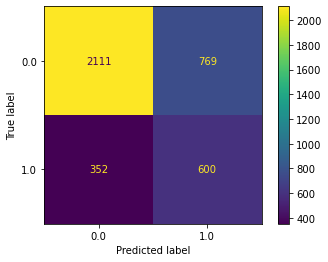

In [22]:
lr_tuned.fit(X_train_val, y_train_val)
plot_confusion_matrix(lr_tuned, X_test, y_test)

D:\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


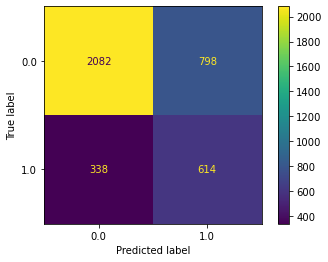

In [23]:
lr_pipe_combine.fit(X_train_val, y_train_val)
plot_confusion_matrix(lr_pipe_combine, X_test, y_test)

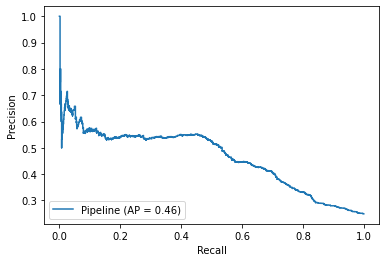

In [24]:
plot_precision_recall_curve(lr_tuned, X_test, y_test)

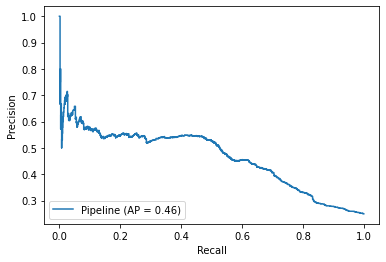

In [25]:
plot_precision_recall_curve(lr_pipe_combine, X_test, y_test)

# Since the base model have higher score. im gonna use the base model

In [26]:
lr_pipe_combine.fit(X,y)
filename = 'LogisticRegression.sav'
pickle.dump(lr_pipe_combine, open(filename, 'wb'))

D:\ANACONDA\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
